In [274]:
import re
from bs4 import BeautifulSoup
import pandas as pd
import glob, os
import matplotlib.pyplot as plt

In [301]:
with open("archtype_profiles\\profile_archtype_drugsbypost.txt", 'r', encoding = "utf-8") as temp:
    profile_html = temp.read()

soup = BeautifulSoup(profile_html, "html.parser")

In [312]:
def get_profiles_info(profiles):
    #####################
    ###### Vendor #######
    #####################
    def get_vendor_info(soup):
        VENDOR_NAME = soup.find("h1", {"class": "text-white text-4xl font-light leading-tight mr-4"}).text.strip()

        vendor_info = soup.find("span", {"class":"leading-tight font-mono font-bold text-xs text-gray-600"}).text.split("·")
        JOIN_DATE = vendor_info[0].strip().strip("Joined").strip()
        NUM_POSTS = int(vendor_info[1].strip().strip("Posts:").strip())
        NUM_COMMENTS = int(vendor_info[2].strip().strip("Comments:").strip())
        NUM_WIKI_EDITS = int(vendor_info[3].strip().strip("ArcheWiki edits:").strip())

        terms_bio = soup.findAll("div", {"class" : "bg-gray-900 rounded-md shadow-md text-gray-500 text-sm font-mono overflow-y-auto p-6 w-full break-words whitespace-pre-line"})
        TERMS_AND_COND = terms_bio[0].text.strip()
        BIO = terms_bio[1].text.strip()

        begin_tag = "-----BEGIN PGP PUBLIC KEY BLOCK-----"
        end_tag   = "-----END PGP PUBLIC KEY BLOCK-----"
        PGP_KEY = soup.find("textarea", {"class" : "bg-gray-800 rounded-md shadow-md text-gray-500 text-xs font-mono overflow-y-auto p-3 w-full"}).text
        PGP_KEY = PGP_KEY.strip(begin_tag).strip(end_tag)

        VENDOR_INFO =  {"Vendor": {"Name": VENDOR_NAME,
                            "Join date": JOIN_DATE,
                            "Number of posts": NUM_POSTS,
                            "Number of Comments by user": NUM_COMMENTS,
                            "Number of wiki edits": NUM_WIKI_EDITS,
                            "Terms and Conditions": TERMS_AND_COND,
                            "Bio": BIO,
                            "PGP-key": PGP_KEY
                                  }}

        return VENDOR_INFO

    #####################
    ###### Products #####
    #####################
    def get_product_info(soup):
        product_divs = soup.findAll("div", {"class" : "p-4 pb-3 pt-0"})
        product_as = [product_div.findAll("a") for product_div in product_divs]

        TYPES = [product_as[i][0].text for i in range(len(product_divs))]
        ADMINISTER = [product_as[i][1].text for i in range(len(product_divs))]
        PRODUCT_NAMES = [product_as[i][2].text for i in range(len(product_divs))]
        PRODUCT_VENDOR = [product_as[i][3].text.strip() for i in range(len(product_divs))]
        PAYMENT_METHOD = [product_as[i][4].text.strip() for i in range(len(product_divs))]

        shipping_info = [product_div.findAll("span", {"class":"text-sm text-gray-400"}) for product_div in product_divs]
        SHIPS_FROM = [shipping_info_elem[0].text for shipping_info_elem in shipping_info]
        SHIPS_TO = [shipping_info_elem[1].text for shipping_info_elem in shipping_info]

        price_infos = soup.findAll("footer", {"class":"rounded-b-md bg-gray-800 flex"})
        price_infos = [price_info.findAll("span", {"class" : "text-gray-300 text-sm"}) for price_info in price_infos]
        QUANTITIES  = [price_info[0].text.split()[0].strip() for price_info in price_infos]
        PRICES  = [int("".join(price_info[1].text.split()[0].strip().split(","))) for price_info in price_infos]
        PRODUCT_KEYS = ["product " + str(i) for i in range(len(product_divs))] 
        IDENTIFIER = [get_vendor_info(soup)["Vendor"]["Name"] for i in range(len(product_divs))]

        PRODUCT_INFO = {PRODUCT_KEYS[i] : {
            "Product Name" : PRODUCT_NAMES[i],
            "Type": TYPES[i],
            "Specific Type" : ADMINISTER[i],
            "Payment Method" : PAYMENT_METHOD[i],
            "Vendor": PRODUCT_VENDOR[i],
            "Ships From": SHIPS_FROM[i],
            "Ships To": SHIPS_TO[i],
            "Order Quantity": QUANTITIES[i],
            "Price" : PRICES[i],
            "IDENTIFIER": IDENTIFIER[i]
        } for i in range(len(PRODUCT_KEYS))}

        return PRODUCT_INFO
    
    df_vendors  = pd.DataFrame()
    df_products = pd.DataFrame()
#     df_discussions = pd.DataFrame()
#     df_feedback = pd.DataFrame()
    
    for profile in profiles:
        with open(profile, 'r', encoding = "utf-8") as temp:
            profile_html = temp.read()

        soup = BeautifulSoup(profile_html, "html.parser")
        
        df_vendors = pd.concat([df_vendors, pd.DataFrame(get_vendor_info(soup)).T])
        df_products = pd.concat([df_products, pd.DataFrame(get_product_info(soup)).T])
#         df_discussions = pd.concat([df_discussions, get_discussion_info(soup)])
#         df_feedback = pd.concat([df_feedback, get_feedback(soup)])
        
    
    df_vendors.to_csv("ARCHTYPE_vendor_info.csv")
    df_products.to_csv("ARCHTYPE_products_info.csv")
#     df_discussions.to_csv("VICECITY_discussions_info.csv")
#     df_feedback.to_csv("VICECITY_feedback_info.csv")

    return df_vendors, df_products


In [313]:
profiles = []
for file in os.listdir("./archtype_profiles"):
    if file.endswith(".txt"):
        profiles += [os.path.join("./archtype_profiles", file)]

In [314]:
df_vendors, df_products = get_profiles_info(profiles)

In [330]:
[row for idx, row in df_products.iterrows() if row["Price"] == 100]

[Product Name      AMNESIA  -50% OFFERTA
 Type                           Cannabis
 Specific Type            Buds & Flowers
 Payment Method                   Escrow
 Vendor                            1Elle
 Ships From                        Italy
 Ships To                         Europe
 Order Quantity                      10g
 Price                               100
 IDENTIFIER                        1Elle
 Name: product 3, dtype: object,
 Product Name      30g or 60g SugarLeafs/Trim/Popcorn Buds
 Type                                             Cannabis
 Specific Type                            Shake & Cuttings
 Payment Method                                     Escrow
 Vendor                                     CaliforniaGirl
 Ships From                                        Germany
 Ships To                                           Europe
 Order Quantity                                        30g
 Price                                                 100
 IDENTIFIER               

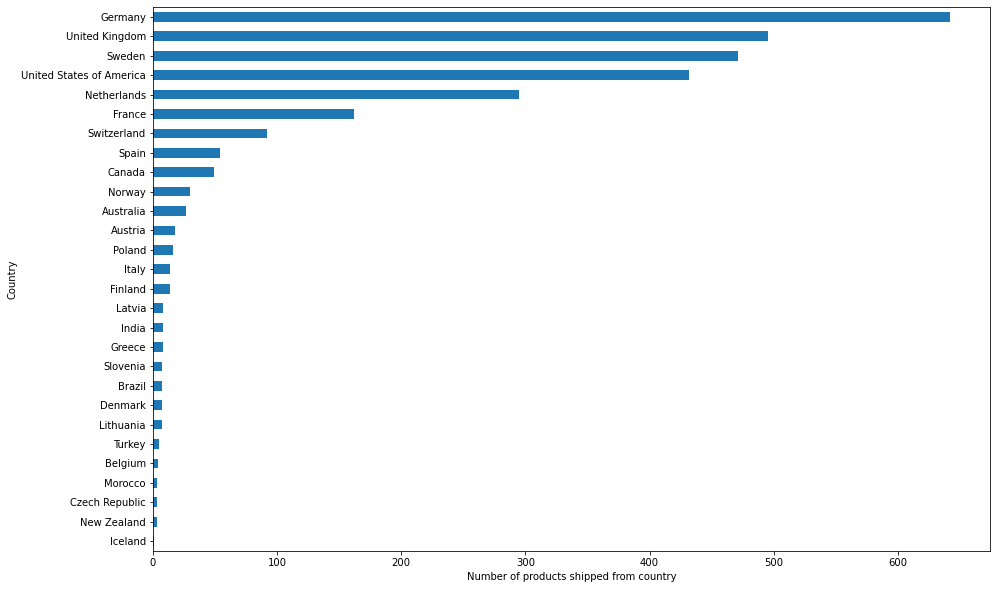

In [343]:
df_products["Ships From"].value_counts(ascending = True).plot(kind = "barh", figsize = (15,10))
plt.xlabel("Number of products shipped from country")
plt.ylabel("Country")
plt.show()